<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/fMRI/load_fslcourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/projects/fMRI/load_fslcourse.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Load the FSL course task dataset

We provide data from 2 Tasks. Please watch the data loading video for more details on the tasks but briefly:

- Task 1 : `Fluency`. This is an event related design with three types of events: 
  - Word-generation events (WG): The subject is presented with a noun, e.g "car" and must come up with a pertinent verb (e.g. "drive") and then "think that word in their head". The subject was explicitly instructed never to say or even mouth a word to prevent movement artefacts.
  - Word-shadowing events (WS): The subject is presented with a verb and is instructed to simply "think that word in their head".
  - Null-events (N): These are events where nothing happens, i.e. the cross-hair remains on the screen and no word is presented. The purpose of these "events" is to supply a baseline against which the other two event types can be compared.

- Task 2 : `Parametric`. Words were presented at different frequencies. Sentences were presented one word at a time, at frequencies ranging from 50 words per minute (wpm) to 1250 wpm, and the participant just had to read the words as they were presented. This is an example of a parametric experimental design. The hypothesis is that certain brain regions respond more strongly to the optimum reading speed compared to the extremely slow and extremely fast word presentation rates (i.e. you might expect to find an inverted U-shape for the response to the five different levels).



In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib   # neuroimaging I/O library

from nilearn import plotting, image

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
# The download cells will store the data in nested directories starting here:
DATA_DIR = "./fslcourse"
if not os.path.isdir(DATA_DIR):
  os.mkdir(DATA_DIR)

# Description of the two experiments

EXPERIMENTS = {
    'fluency' : {
     'TR'     : 4.2,         # time resolution in seconds
     'ntimes' : 106,         # number of time points
     'EVs'    : ['Gen','Shad']  # conditions
     },
    'parametric' : {
     'TR'     : 0.933,
     'ntimes' : 1100,
     'EVs'    : ['WPM_0050','WPM_0350','WPM_0650','WPM_0950','WPM_1250']
     }
}

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
# @title Download and unzip the data in `DATA_DIR`
import os, shutil, requests, tarfile

fname = "fslcourse.tgz"
url = "https://osf.io/syt65/download/"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print("Downloading data...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      # open file
      with tarfile.open(fname) as fzip:
        fzip.extractall(DATA_DIR)
      print("Download completed!")
else:
  print("Data have been already downloaded!")

Download completed!


# Helper functions
We provide three helper functions: 

- one for loading the EV file for each task. EV:Explanatory Variable describes the task experiment in terms of stimulus onset, duration, and amplitude.

- one for generating a haemodynamic response function. this one is super basic and not at all phyysiological. consider replacing with something that makes more sense.

- a function that runs a simple general linear model (or multiple regression of X on Y) and produces t-statistics. It also allows you to generate these statistics for linear combinations of parameter estimates (aka contrasts). This will be handy for the `parametric` data where you can ask whether brain activity changes linearly/quadratically with the stimulus

In [ ]:
# @title Helper functions
def load_evs(exp, dir):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    experiment (str) : Name of experiment
    dir (str) : Data directory

  Returns
    evs (dict)

  """
  TR = EXPERIMENTS[exp]['TR']
  EVs = []
  for ev in EXPERIMENTS[exp]['EVs']:
    ev_file = os.path.join(dir, exp, "EVs", f"{ev}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    a = np.zeros(EXPERIMENTS[exp]['ntimes'])
    for frame in frames:
      a[frame] = 1
    EVs.append(a)
  return dict(zip(EXPERIMENTS[exp]['EVs'], EVs))


def get_HRF(duration, TR, peak):
  """
  Really dumb Haemodynamic response function (not physiologically plausible)
  It simply goes up and down linearly from 0 to peak and back down

  Args:
    duration (float) : in seconds
    TR (float)       : in seconds
    peak (float)     : in seconds

  Returns:
    1D array
  """
  n = int(np.ceil(duration / TR))
  x = np.linspace(0, duration, n)
  h = np.zeros(n)
  h[x < peak]  = x[x < peak] / peak
  h[x >= peak] = (x[x >= peak] - duration) / (peak - duration)
  h = h / np.sum(h)
  return h


def glm(Y, X, C=None, mask=None):
  """
  Run a general linear model

  Args:
    Y (2d array) : time-by-space data matrix
    X (2d array) : time-by-regressors design matrix
    C (2d array) : contrasts-by-regressor contrrast matrix [default=Identity]
    mask (1d array) : spatial mask wherre GLM is run

  Returns:
    contrast maps
    t-stats
  """
  if C is None:
    C = np.identity(X.shape[1])
  if mask is None:
    mask = np.ones(Y.shape[1])

  # initialise matrices
  beta = np.zeros((X.shape[1], Y.shape[1]))
  cope = np.zeros((C.shape[0], Y.shape[1]))
  varbeta = np.zeros_like(beta)
  tstat = np.zeros_like(beta)

  # solve glm
  beta[:, mask > 0] = np.linalg.pinv(X) @ Y[:, mask > 0]
  # apply contrasts
  cope[:, mask > 0] = np.dot(C, beta[:, mask > 0])

  # calculate uncertainty (varcope)
  r = Y - X@beta
  dof = X.shape[0] - np.linalg.matrix_rank(X)
  sig2 = np.sum(r**2, axis=0) / dof
  varcope = np.outer(C @ np.diag(np.linalg.inv(X.T @ X)) @ C.T, sig2)
  # calculate t-stats
  tstat[:, mask] = cope[:, mask] / np.sqrt(varcope[:, mask])

  return cope, tstat

# Simple analysis

To familiarise ourselves with the data, we will do a simple  analysis where we model the data as a linear combination of two task regressor plus a baseline. 

We first load the data, load the EVs.

In [ ]:
# Use nibabel to load the data
img = nib.load(os.path.join(DATA_DIR, "fslcourse_data",
                            "fluency", "fmri_data.nii.gz"))

# get the actual data using the img nibabel Object
# this returns a numpy array
data = img.get_fdata()

# Understand the dimensions of the data
print(data.shape)  # x-by-y-by-z-by-time

(91, 109, 91, 106)


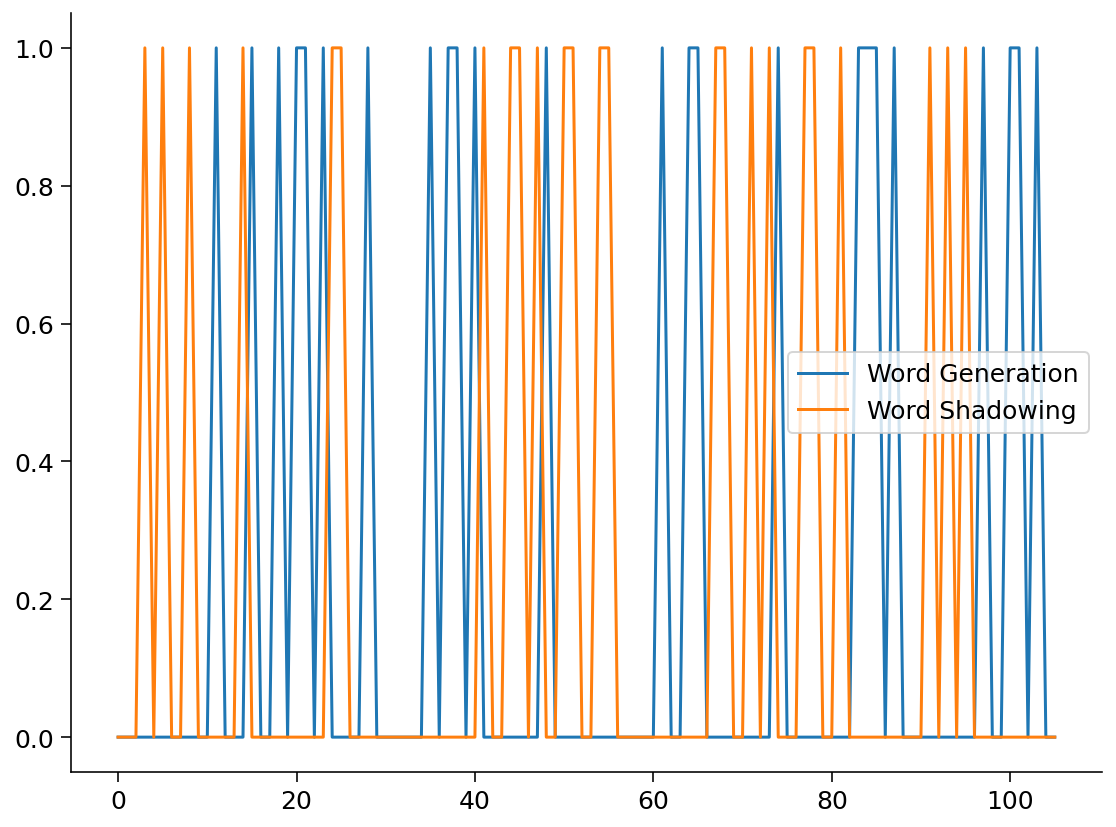

In [ ]:
# Load and plot the two EVs
plt.figure()
plt.plot(load_evs('fluency', os.path.join(DATA_DIR, "fslcourse_data"))['Gen'],
                  label='Word Generation')
plt.plot(load_evs('fluency', os.path.join(DATA_DIR, "fslcourse_data"))['Shad'],
         label='Word Shadowing')
plt.legend()
plt.show()

Next we will convolve ouur regressors with the HRF. This is because the FMRI signal is a sluggish blood signal that lags behind neural signal. 

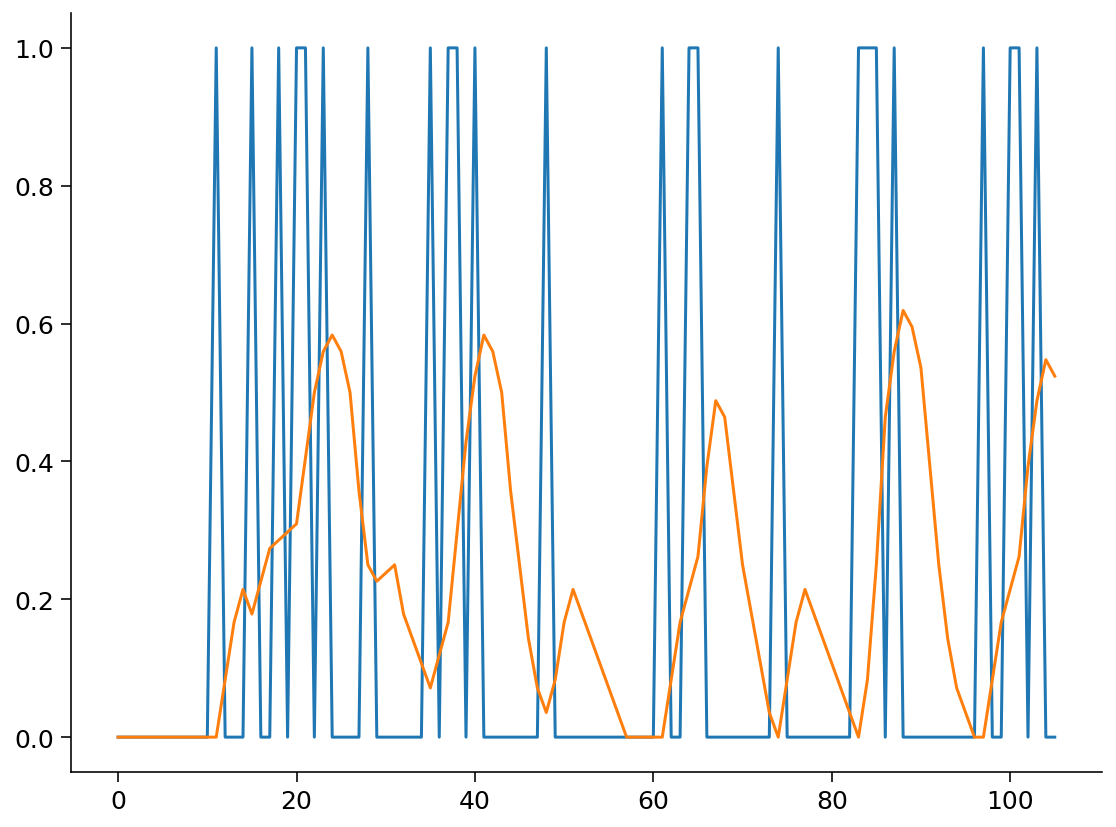

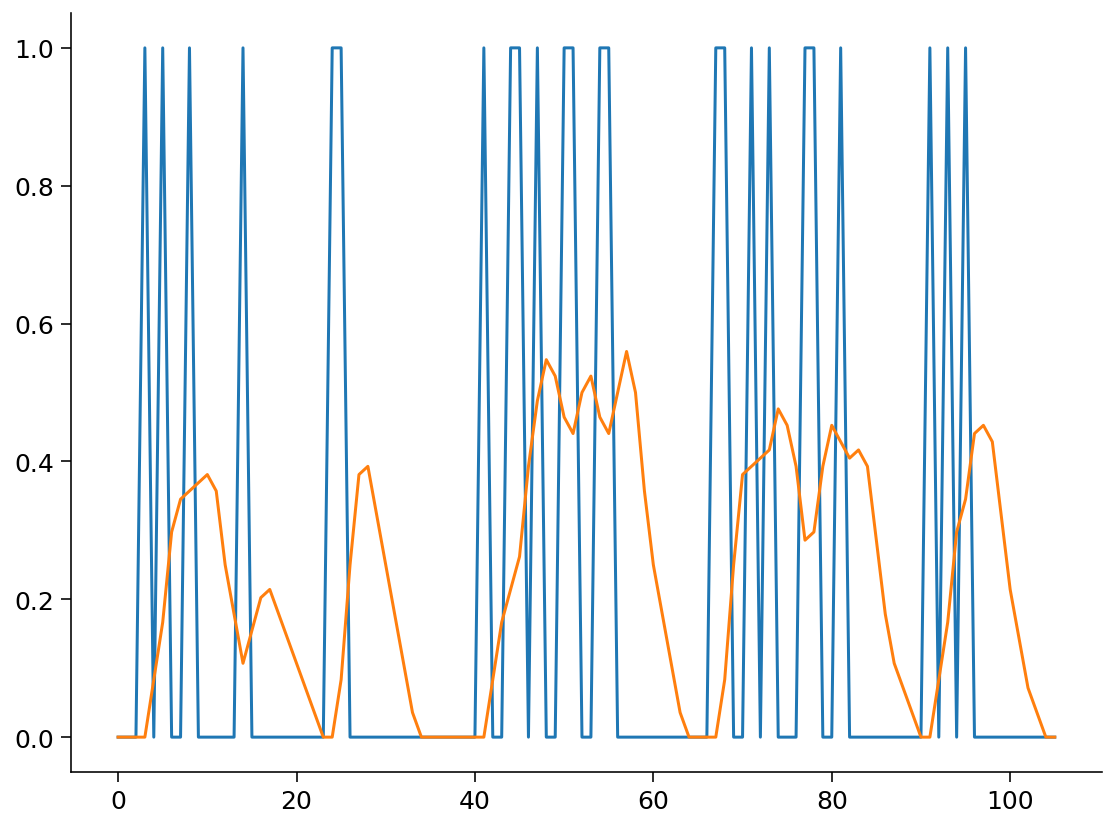

In [ ]:
HRF = get_HRF(duration=10, TR=1, peak=3)
EVs = load_evs('fluency', os.path.join(DATA_DIR, "fslcourse_data"))
n = len(EVs['Gen'])
ev1 = np.convolve(EVs['Gen'], HRF, 'full')[:n]
ev2 = np.convolve(EVs['Shad'], HRF, 'full')[:n]

# plot the new EVs:
plt.figure()
plt.plot(EVs['Gen'])
plt.plot(ev1)
plt.show()

plt.figure()
plt.plot(EVs['Shad'])
plt.plot(ev2)
plt.show()

Next we create the design matrix to use in the GLM. 

(106, 3)


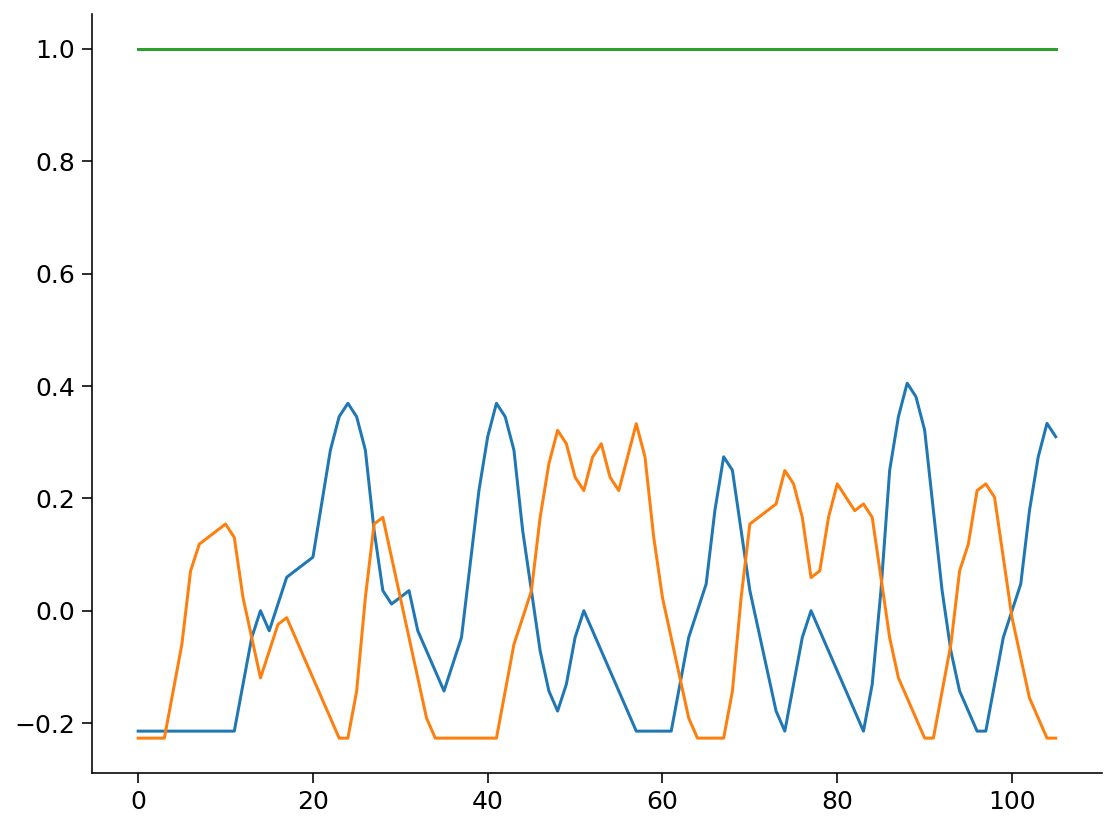

In [ ]:
# demean the task regressors
ev1 = ev1 - np.mean(ev1)
ev2 = ev2 - np.mean(ev2)

# append a constant regressor
design_matrix = np.asarray([ev1, ev2, np.ones_like(ev1)]).T
print(design_matrix.shape)

plt.figure()
plt.plot(design_matrix)
plt.show()

Next we do the GLM. We provide a helper function to calcculate a T-statistic for each of the regression coefficients by dividing eacch coefficient by its uncertainty (varbeta)

In [ ]:
# turn 4D data array to 2D (N-by-time)
Y = np.reshape(data, (np.prod(data.shape[:3]), -1)).T

# create a mask where data is non-zero
mask = np.sum(Y**2, axis=0)>0

# run GLM
beta, t = glm(Y=Y, X=design_matrix, mask=mask)

# turn back to 4D arrays
shape = list(data.shape[:3])
shape.append(beta.shape[0])
beta_r = np.reshape(beta.T,shape)
t_r = np.reshape(t.T,shape)

[4.17454407e+00 5.02199456e-01 1.06128657e+03]


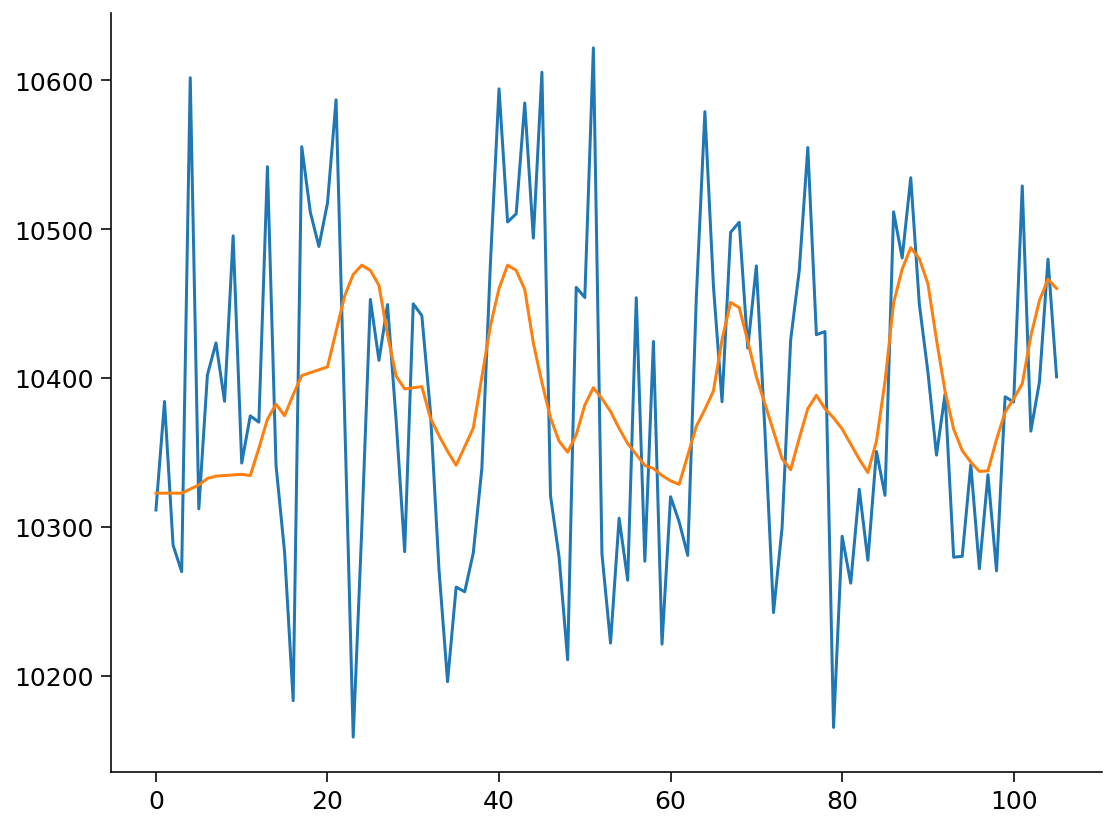

In [ ]:
# Look at fit for best voxel
idx = np.argmax(t[0, :])
print(t[:, idx])

plt.figure()
plt.plot(Y[:, idx])
plt.plot(design_matrix @ beta[:, idx])
plt.show()

# Visualisation

We will use nilearn to visualise the GLM results on a brain

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


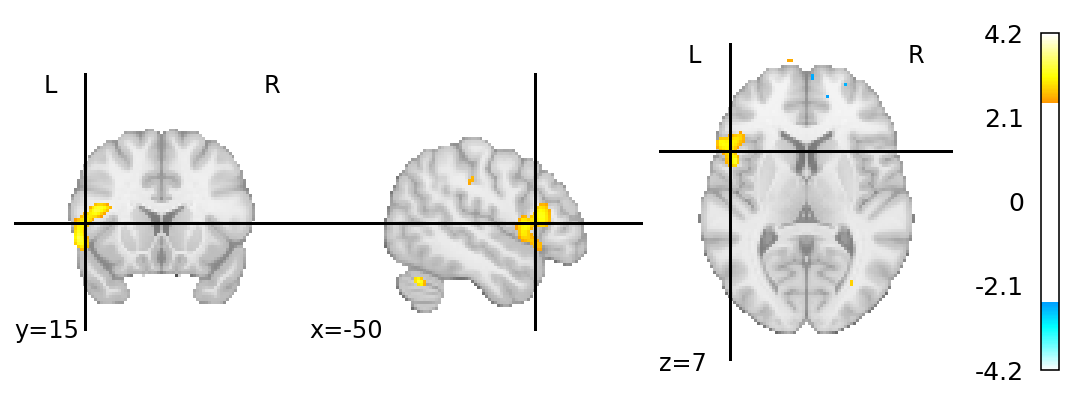

In [ ]:
# This uses the nilearn package

# select Word Gen contrast
tt  = t_r[..., 0]

# turn into nilearn image object
map = image.new_img_like(img, tt, copy_header=True)

# use to display (assumes that the map is in MNI standard space, which it is because the data is)
plotting.plot_stat_map(map, threshold=2.5)

You should be able to see that, despite using such a cheap and cheerful model, we can see activity in Broca's area. Woohoo!


That's it for now. You can try different HRF models, or get the parametric data and try to see if you can model U-shaped brain responses with the appropriate contrast matrix.
